# ANALYSIS

In [ ]:
#uncomment this below code to install imblearn package
# !pip install imbalanced-learn

In [1]:
import pandas as pd
import numpy as np
import sklearn

#statistics
from scipy.stats import chi2_contingency, ttest_ind

import cudf #gpu-powered DataFrame (Pandas alternative)

#imbalance handling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, RepeatedEditedNearestNeighbours
from imblearn.pipeline import Pipeline

#preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler


#internal validation
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedStratifiedKFold, cross_val_score, GridSearchCV, PredefinedSplit, train_test_split

#performance metrices
from sklearn.metrics import confusion_matrix, classification_report, f1_score, balanced_accuracy_score, matthews_corrcoef, auc, average_precision_score, roc_auc_score, balanced_accuracy_score, roc_curve, accuracy_score

#Models selection
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from cuml.svm import SVC #gpu-powered SVM



#save and load trained model
import pickle

#visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree

from collections import Counter
import os

In [2]:
# Data loader
features = pd.read_csv("../FinalData/cleaned_features_11072023.csv")
outcomes = pd.read_csv("../FinalData/cleaned_outcomes_11072023.csv")
features = features[features.columns[1:]]
# outcomes = outcomes[outcomes.columns[1:]]

/tmp/ipykernel_162/3164845275.py:2: DtypeWarning: Columns (26,27,29,30,33,34,68,72) have mixed types. Specify dtype option on import or set low_memory=False.
  features = pd.read_csv("../FinalData/cleaned_features_11072023.csv")


In [3]:
print(features.shape)
print(outcomes.shape)

(577962, 87)
(577962, 15)


In [4]:
features.columns

Index(['patid', 'practice_id', 'sex', 'age', 'BMI', 'weight', 'height',
       'ethnicity', 'ethnic_group', 'smokingStatus', 'CharlsonScore',
       'count_rhinitis', 'count_cardiovascular', 'count_heartfailure',
       'count_psoriasis', 'count_anaphylaxis', 'count_diabetes', 'count_ihd',
       'count_anxiety', 'count_eczema', 'count_nasalpolyps',
       'count_paracetamol', 'count_nsaids', 'count_betablocker', 'id',
       'event_date', 'recorded_date', 'visit_id', 'code_id', 'snomed_id',
       'numeric_1', 'numeric_2', 'created_datetime', 'updated_datetime',
       'PEFStatus', 'EosinophilLevel', 'BTS_step', 'average_daily_dose_ICS',
       'prescribed_daily_dose_ICS', 'ICS_medication_possesion_ratio',
       'DeviceType', 'Spacer', 'numOCS', 'PriorEducation', 'numPCS',
       'numPCSAsthma', 'numAntibioticsEvents', 'numAntibioticswithLRTI',
       'numOCSEvents', 'numOCSwithLRTI', 'numAsthmaAttacks',
       'numAcuteRespEvents', 'numHospEvents', 'postcode_district',
       'imd_d

In [5]:
features.head()

,patid,practice_id,sex,age,BMI,weight,height,ethnicity,ethnic_group,smokingStatus,...,psoriasis,anaphylaxis,diabetes,ihd,anxiety,eczema,nasalpolyps,paracetamol,nsaids,betablocker
0,43231452,39,0.0,48,26.609713,76.0,1.6900,not_recorded,not_recorded,Active Smoker,...,0,0,0,0,0,0,0,0,0,0
1,43206365,39,1.0,58,23.946360,72.5,1.7400,not_recorded,not_recorded,Former Smoker,...,0,0,0,0,1,0,0,0,0,0
2,43203606,559,0.0,51,17.104513,39.0,1.5100,not_recorded,not_recorded,Active Smoker,...,0,0,0,0,0,1,0,0,0,0
3,43117348,502,0.0,69,35.303241,74.0,1.4478,not_recorded,not_recorded,Former Smoker,...,1,0,0,0,0,1,0,0,0,0
4,43289035,593,0.0,49,31.217482,75.0,1.5500,White British,White - ethnic group,Active Smoker,...,0,0,0,0,0,1,0,0,0,0


In [6]:
outcomes.head()

,patid,outcome_3months,outcome_6months,outcome_9months,outcome_12months,outcome_15months,outcome_18months,outcome_21months,outcome_24months,outcome_combined_6months,outcome_combined_9months,outcome_combined_12months,outcome_combined_15months,outcome_combined_18months,outcome_combined_24months
0,43231452,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,43206365,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,43203606,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,43117348,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,43289035,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
masterData = features.merge(outcomes, how = 'left', left_on='patid', right_on='patid') #join table
# masterData = masterData.dropna() #NAs from Country
masterData = masterData.reset_index(drop=True)
exclude_columns = ['weight', 'height', 'id', 'event_date', 'recorded_date', 'visit_id', 'code_id', 'snomed_id',
       'numeric_1', 'numeric_2', 'created_datetime', 'updated_datetime',]
masterData = masterData.loc[:,~masterData.columns.isin(exclude_columns)]
masterData = masterData.rename({'outcome_3months': '3months', 'outcome_combined_6months': '6months','outcome_combined_12months': '12months','outcome_combined_24months': '24months',}, axis=1)
print('original data shape: ', masterData.shape)

original data shape:  (577962, 89)


In [8]:
#Data scenario
# 1: all data without ethnicity variable
# 2: all data with ethnicity variable (include all missing values in ethnicity as separate group)
# 3: filter data based on ethnicity (exclude missing values)

scenario = 1 #change it based on the scenario

if scenario == 1:
    #include all data
    allData = masterData
    
elif scenario == 2:
    #Exclude ethnic column
    allData = masterData.drop('ethnic_group', axis=1)
    
elif scenario == 3:
    #exclude missing values for ethnic variable
    allData = masterData[masterData.ethnic_group!='not_recorded']
    
allData = allData.reset_index(drop=True)
print('Data shape for scenario', str(scenario), allData.shape)



Data shape for scenario 1 (577962, 89)


In [9]:
# #Split data into training and evaluation set based on the country. Include only 18+ patients.

# trainingData = allData[(allData.Country == 'England') & (allData.age>=18)]
# evaluationData = allData[((allData.Country == 'Scotland') | (allData.Country == 'Wales')) & (allData.age>=18)] #used for validation
# evaluationDataWales = allData[(allData.Country == 'Wales') & (allData.age>=18)] #used for validation
# evaluationDataScotland = allData[(allData.Country == 'Scotland') & (allData.age>=18)] #used for validation

# #remove country variable
# trainingData = trainingData.drop('Country', axis=1)
# evaluationData = evaluationData.drop('Country', axis=1)
# evaluationDataWales = evaluationDataWales.drop('Country', axis=1)
# evaluationDataScotland = evaluationDataScotland.drop('Country', axis=1)

# trainingData = trainingData.reset_index(drop=True)
# evaluationData = evaluationData.reset_index(drop=True)
# evaluationDataWales = evaluationDataWales.reset_index(drop=True)
# evaluationDataScotland = evaluationDataScotland.reset_index(drop=True)

# print('Training data shape:', trainingData.shape)
# print('Evaluation data shape: ', evaluationData.shape)
# print('Evaluation data Wales shape: ', evaluationDataWales.shape)
# print('Evaluation data Scotland shape: ', evaluationDataScotland.shape)

In [10]:
#Split data into training and evaluation set based on the country. Include only 18+ patients.
trainingData, evaluationData = train_test_split(allData, test_size=0.038282, shuffle=True, stratify=allData[['Country']])

#check the proportion of each country in both sets
print("proportion of each country: ")
print(trainingData.Country.value_counts(normalize=True))
print(evaluationData.Country.value_counts(normalize=True))

print('Training data shape:', trainingData.shape)
print('Evaluation data shape: ', evaluationData.shape)

#remove country variable
trainingData = trainingData.drop('Country', axis=1)
evaluationData = evaluationData.drop('Country', axis=1)

trainingData = trainingData.reset_index(drop=True)
evaluationData = evaluationData.reset_index(drop=True)



proportion of each country: 
England     0.961717
Wales       0.024498
Scotland    0.013785
Name: Country, dtype: float64
England     0.961719
Wales       0.024496
Scotland    0.013785
Name: Country, dtype: float64
Training data shape: (555836, 89)
Evaluation data shape:  (22126, 89)


In [11]:
target_outcomes = ['3months', '6months', '12months', '24months'] 
for target_outcome in target_outcomes:
    print('#######################################################')
    print(target_outcome)
    print(trainingData[target_outcome].value_counts(normalize=True))
    print(evaluationData[target_outcome].value_counts(normalize=True))

#######################################################
3months
0    0.97271
1    0.02729
Name: 3months, dtype: float64
0    0.972476
1    0.027524
Name: 3months, dtype: float64
#######################################################
6months
0    0.959089
1    0.040911
Name: 6months, dtype: float64
0    0.959776
1    0.040224
Name: 6months, dtype: float64
#######################################################
12months
0    0.930924
1    0.069076
Name: 12months, dtype: float64
0    0.932116
1    0.067884
Name: 12months, dtype: float64
#######################################################
24months
0    0.898439
1    0.101561
Name: 24months, dtype: float64
0    0.898807
1    0.101193
Name: 24months, dtype: float64


In [12]:
#encode categorical data

cat_vars = ['PEFStatus','EosinophilLevel']
onehot_vars = ['ethnic_group','smokingStatus', 'DeviceType', 'cat_BMI', 'imd_decile']
data_categorical = trainingData[cat_vars]
data_onehot = trainingData[onehot_vars]

#ordinal encoder
encoder = OrdinalEncoder(categories=[['not_recorded','less than 60', '60-80', 'more than 80'], ['unknown', 'normal', 'high']]).set_output(transform="pandas")
data_encoded = encoder.fit_transform(data_categorical)
pickle.dump(encoder, open('../Models/cat_encoder.pkl', 'wb'))
    
#one hot encoder
onehot_encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
onehot_encoded = onehot_encoder.fit_transform(data_onehot)
pickle.dump(onehot_encoder, open('../Models/onehot_encoder.pkl', 'wb'))

trainingData = pd.concat([trainingData.drop(cat_vars, axis=1), data_encoded], axis=1)
trainingData = pd.concat([trainingData.drop(onehot_vars, axis=1), onehot_encoded], axis=1)

print('Data shape after encoding: ', trainingData.shape)

Data shape after encoding:  (555836, 113)


In [13]:
#encode cat vars for evaluation set
data_eval_categorical = evaluationData[cat_vars]
data_eval_onehot = evaluationData[onehot_vars]


encoder = pickle.load(open('../Models/cat_encoder.pkl', 'rb'))
data_eval_encoded = encoder.transform(data_eval_categorical)


onehot_encoder = pickle.load(open('../Models/onehot_encoder.pkl', 'rb'))
onehot_eval_encoded = onehot_encoder.transform(data_eval_onehot)


evaluationData = pd.concat([evaluationData.drop(cat_vars, axis=1), data_eval_encoded], axis=1)
evaluationData = pd.concat([evaluationData.drop(onehot_vars, axis=1), onehot_eval_encoded], axis=1)


print('Data shape after encoding: ', evaluationData.shape)


Data shape after encoding:  (22126, 113)


In [14]:
#Data normalisation for continous variable into 0-1 range


continuous_vars = ['age', 'CharlsonScore', 'average_daily_dose_ICS', 'prescribed_daily_dose_ICS', 'ICS_medication_possesion_ratio', 
                   'numOCS', 'numPCS', 'numPCSAsthma', 'numAntibioticsEvents', 'numAntibioticswithLRTI', 'numOCSEvents', 'numOCSwithLRTI', 
                   'numAsthmaAttacks', 'numAcuteRespEvents', 'numHospEvents']

# define scaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(trainingData[continuous_vars])
pickle.dump(scaler, open('../Models/cont_scaler.pkl', 'wb'))


data_scaled = pd.DataFrame(data_scaled, columns=scaler.get_feature_names_out())
trainingData = pd.concat([trainingData.drop(continuous_vars, axis=1), data_scaled], axis=1)

print('Data shape after scaling: ', trainingData.shape)

Data shape after scaling:  (555836, 113)


In [15]:
#Normalisation for evaluation data

scaler = pickle.load(open('../Models/cont_scaler.pkl', 'rb'))
data_eval_scaled = scaler.transform(evaluationData[continuous_vars])


data_eval_scaled = pd.DataFrame(data_eval_scaled, columns=scaler.get_feature_names_out())
evaluationData = pd.concat([evaluationData.drop(continuous_vars, axis=1), data_eval_scaled], axis=1)


print('Data shape after scaling: ', evaluationData.shape)


Data shape after scaling:  (22126, 113)


In [16]:
#Define feature candidates

features_columns = trainingData.columns.to_list()
exclude_columns = ['patid', 'practice_id', #identifier
                   'BMI', #use the categorical instead
                   'ethnicity', #use ethnic_group instead
                   'Spacer',  #all zero
                   
                   'outcome_3months', 'outcome_6months', 'outcome_9months', 'outcome_12months', 'outcome_15months', 'outcome_18months', 
                   'outcome_21months', 'outcome_24months', 'outcome_combined_6months', 'outcome_combined_9months', 'outcome_combined_12months', 
                   'outcome_combined_15months', 'outcome_combined_18months', 'outcome_combined_24months', '3months', '6months', '12months', '24months', #outcomes variable
                   
                   'postcode_district', 'County', 'LocalAuthority', 'OutputAreaClassification', #location related variables, use IMD decile only
                   
                   'cat_age', 'cat_average_daily_dose_ICS', 'cat_prescribed_daily_dose_ICS', 'cat_ICS_medication_possesion_ratio', 'cat_numOCS', 'cat_numOCSEvents', 
                   'cat_numOCSwithLRTI', 'cat_numAcuteRespEvents', 'cat_numAntibioticsEvents', 'cat_numAntibioticswithLRTI', 'cat_numAsthmaAttacks', 'cat_numHospEvents', 
                   'cat_numPCS', 'cat_numPCSAsthma', #use continous vars instead
                   
                   'count_rhinitis', 'count_cardiovascular', 'count_heartfailure',
                   'count_psoriasis', 'count_anaphylaxis', 'count_diabetes', 'count_ihd',
                   'count_anxiety', 'count_eczema', 'count_nasalpolyps',
                   'count_paracetamol', 'count_nsaids', 'count_betablocker', #use binary ones
                  ]
exclude_columns = exclude_columns + [x for x in features_columns if '_count' in x] #filter out commorbid count variables
features_columns = [x for x in features_columns if x not in exclude_columns]
print('Features size: ', len(features_columns))
print(features_columns)

Features size:  63
['sex', 'BTS_step', 'PriorEducation', 'rhinitis', 'cardiovascular', 'heartfailure', 'psoriasis', 'anaphylaxis', 'diabetes', 'ihd', 'anxiety', 'eczema', 'nasalpolyps', 'paracetamol', 'nsaids', 'betablocker', 'PEFStatus', 'EosinophilLevel', 'ethnic_group_Asian - ethnic group', 'ethnic_group_Black - ethnic group', 'ethnic_group_Mixed ethnic census group', 'ethnic_group_Other ethnic group', 'ethnic_group_White - ethnic group', 'ethnic_group_not_recorded', 'smokingStatus_Active Smoker', 'smokingStatus_Former Smoker', 'smokingStatus_Non Smoker', 'DeviceType_BAI', 'DeviceType_DPI', 'DeviceType_NEB', 'DeviceType_pMDI', 'DeviceType_unknown', 'cat_BMI_normal', 'cat_BMI_not recorded', 'cat_BMI_obese', 'cat_BMI_overweight', 'cat_BMI_underweight', 'imd_decile_0', 'imd_decile_1', 'imd_decile_2', 'imd_decile_3', 'imd_decile_4', 'imd_decile_5', 'imd_decile_6', 'imd_decile_7', 'imd_decile_8', 'imd_decile_9', 'imd_decile_10', 'age', 'CharlsonScore', 'average_daily_dose_ICS', 'prescrib

In [ ]:
#ONE HOT encoding for categorical data

# categoricalNonnumericVars = pd.Series(list(set(categoricalNonnumericVars).intersection(set(features_columns)))).tolist() #select only variables within the feature candidate list

# # define one hot encoder
# categoricalEncoder = OneHotEncoder(sparse=False)

# # transform data
# result = categoricalEncoder.fit_transform(trainingData[categoricalNonnumericVars]) 
# result = pd.DataFrame(result, columns=categoricalEncoder.get_feature_names_out())

# #save encoder
# pickle.dump(categoricalEncoder, open('./models/categoricalEncoder.pkl', 'wb'))

# # replace categorical variables in the original data with the one hot version
# trainingData = pd.concat([trainingData.loc[:, ~trainingData.columns.isin(categoricalNonnumericVars)],result], axis=1)
# print('Data shape after one-hot encoding: ', trainingData.shape)

In [ ]:
# #Scaling continous variable into 0-1 range

# # summaryData = allData.describe().T
# continuous_vars = summaryData[summaryData['max'] >5].index.to_list() + ['numHospEvents'] #Num hospital events is continuous with 
# continuous_vars = pd.Series(list(set(continuous_vars).intersection(set(features_columns)))).tolist() #select only variables within the feature candidate list

# # define scaler
# scaler = MinMaxScaler()

# #save scaler
# pickle.dump(scaler, open('./models/scaler.pkl', 'wb'))


# # transform data
# result = scaler.fit_transform(trainingData[continuous_vars])
# result = pd.DataFrame(result, columns=scaler.get_feature_names_out())

# allData = pd.concat([trainingData.loc[:,~trainingData.columns.isin(continuous_vars)],result], axis=1)

# print('Data shape after scaling: ', trainingData.shape)

In [ ]:
# #ONE HOT encoding for evaluation dataset

# # transform data
# result = categoricalEncoder.transform(evaluationData[categoricalNonnumericVars]) 
# result = pd.DataFrame(result, columns=categoricalEncoder.get_feature_names_out())

# # replace categorical variables in the original data with the one hot version
# evaluationData = pd.concat([evaluationData.loc[:, ~evaluationData.columns.isin(categoricalNonnumericVars)],result], axis=1)
# print('Data shape after one-hot encoding: ', evaluationData.shape)

In [ ]:
# #Scaling continous variable into 0-1 range for evaluation dataset


# # transform data
# result = scaler.transform(evaluationData[continuous_vars])
# result = pd.DataFrame(result, columns=scaler.get_feature_names_out())

# evaluationData = pd.concat([evaluationData.loc[:,~evaluationData.columns.isin(continuous_vars)],result], axis=1)

# print('Data shape after scaling: ', evaluationData.shape)

# UTILS

In [17]:
#Model evaluation function

def summariseResult (testX, testY, model):
    preds = model.predict(testX)
    tn, fp, fn, tp = confusion_matrix(testY, preds).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    ppv = 100*tp/(tp+fp)
    npv = 100*tn/(fn+tn)
    acc = accuracy_score(testY, preds)
    f1score = f1_score(testY, preds, average = 'binary')
    balanceacc = balanced_accuracy_score(testY, preds)
    fpr, tpr, thresholds = roc_curve(testY, preds, pos_label=1)
    # aucscore = auc(fpr, tpr)
    aucscore = roc_auc_score(testY, preds)
    auprc = average_precision_score(testY, preds)
    # plot_confusion_matrix(model, testX, testY, cmap='viridis')  
    return np.round(acc,4), np.round(specificity,4), np.round(sensitivity,4), np.round(aucscore,4), np.round(auprc,4), np.round(balanceacc,4), np.round(f1score,4), np.round(ppv,4), np.round(npv,4)

In [18]:
#Fix model name for visualisation

def modelNameFixer(x):
    if 'liblinear' in x:
        return 'Lasso'
    elif 'GaussianNB' in x:
        return 'GNB'
    elif 'SVC' in x:
        return 'SVC'
    elif 'RandomForest' in x:
        return 'RF'
    elif 'XGB' in x:
        return 'XGBoost'
    elif 'DecisionTree' in x:
        return 'DT'
    else:
        return 'LR'

In [19]:
# instantiate the model (using the default parameters)
def build_models (X_train, y_train, target_outcome, params):
    models = [] #list to store all the models
    print("Building models . . . .")

    #LR
    model = 'LR'
    params = params_dict[(params_dict['outcome']==target_outcome)&(params_dict['model']==model)]['best_params_auc'].tolist()[0]
    params = eval(params)
    print(params)
    lr_model = LogisticRegression(class_weight='balanced', C = params['C'], max_iter=params['max_iter'], solver=params['solver'], random_state=1234)
    lr_model.fit(X_train,y_train)
    pickle.dump(lr_model, open('../Models/'+ target_outcome + '/'+ model + '.sav', 'wb'))
    models.append([model, target_outcome, y_train.value_counts()[1]/y_train.value_counts()[0]]) 
    print("LR done")

    #Lasso
    model = 'Lasso'
    params = params_dict[(params_dict['outcome']==target_outcome)&(params_dict['model']==model)]['best_params_auc'].tolist()[0]
    params = eval(params)
    print(params)
    lasso_model = LogisticRegression(class_weight='balanced',  C = params['C'], max_iter=params['max_iter'], penalty='l1', solver=params['solver'], random_state=1234) #only the LIBLINEAR and SAGA (added in v0.19) solvers handle the L1 penalty
    lasso_model.fit(X_train, y_train)
    pickle.dump(lasso_model, open('../Models/'+ target_outcome + '/'+ model + '.sav', 'wb'))
    models.append([model, target_outcome, y_train.value_counts()[1]/y_train.value_counts()[0]])
    print("Lasso done")

    #GNB
    model = 'NB'
    params = params_dict[(params_dict['outcome']==target_outcome)&(params_dict['model']==model)]['best_params_auc'].tolist()[0]
    params = eval(params)
    print(params)
    gnb_model = GaussianNB(var_smoothing = params['var_smoothing'])
    gnb_model.fit(X_train, y_train)
    pickle.dump(gnb_model, open('../Models/'+ target_outcome + '/'+ model + '.sav', 'wb'))  
    models.append([model, target_outcome, y_train.value_counts()[1]/y_train.value_counts()[0]])
    print("GNB done")

    # #SVM
    # model = 'SVM'
    # params = params_dict[(params_dict['outcome']==target_outcome)&(params_dict['model']==model)]['best_params_auc'].tolist()[0]
    # params = eval(params)
    # print(params)
    # svc_model = SVC(class_weight='balanced', C = params['C'], degree=2, kernel=params['kernel'], random_state=1234, cache_size=1024)
    # svc_model.fit(X_train,y_train)
    # pickle.dump(svc_model, open('../Models/'+ target_outcome + '/'+ model + '.sav', 'wb')) 
    # models.append([model, target_outcome, y_train.value_counts()[1]/y_train.value_counts()[0]])
    # print("SVM done")

    #DT
    model = 'DT'
    params = params_dict[(params_dict['outcome']==target_outcome)&(params_dict['model']==model)]['best_params_auc'].tolist()[0]
    params = eval(params)
    print(params)
    dt_model = DecisionTreeClassifier(class_weight='balanced', max_depth=params['max_depth'], criterion=params['criterion'], splitter=params['splitter'], random_state=1234)
    dt_model.fit(X_train, y_train)
    pickle.dump(dt_model, open('../Models/'+ target_outcome + '/'+ model + '.sav', 'wb'))    
    models.append([model, target_outcome, y_train.value_counts()[1]/y_train.value_counts()[0]])
    print("DT done")

    #RF
    model = 'RF'
    params = params_dict[(params_dict['outcome']==target_outcome)&(params_dict['model']==model)]['best_params_auc'].tolist()[0]
    params = eval(params)
    print(params)
    rf_model = RandomForestClassifier(class_weight='balanced', max_depth=params['max_depth'], criterion=params['criterion'], n_estimators=params['n_estimators'], random_state=1234)
    rf_model.fit(X_train, y_train)
    pickle.dump(rf_model, open('../Models/'+ target_outcome + '/'+ model + '.sav', 'wb'))     
    models.append([model, target_outcome, y_train.value_counts()[1]/y_train.value_counts()[0]])
    print("RF done")



    #XGB
    model = 'XGB'
    params = params_dict[(params_dict['outcome']==target_outcome)&(params_dict['model']==model)]['best_params_auc'].tolist()[0]
    params = eval(params)
    print(params)
    scale_pos_ratio = y_train.value_counts()[0]/y_train.value_counts()[1]
    xgb_model = xgb.XGBClassifier(objective ='binary:logistic', max_depth = params['max_depth'], n_estimators = params['n_estimators'],   
                                  learning_rate=params['learning_rate'], reg_alpha = params['reg_alpha'], reg_lambda = params['reg_lambda'],
                                  importance_type = 'gain', scale_pos_weight = scale_pos_ratio, use_label_encoder=False, tree_method='gpu_hist', 
                                  gpu_id=0, verbosity = 0, random_state = 1234,)
    # xgb_model = xgb.XGBClassifier(objective ='binary:logistic', learning_rate = 0.001, tree_method='gpu_hist', gpu_id=0,  verbosity = 0, random_state = 1234)
    xgb_model.fit(X_train,y_train)
    pickle.dump(xgb_model, open('../Models/'+ target_outcome + '/'+ model+ '.sav', 'wb')) 
    models.append([model,  target_outcome, y_train.value_counts()[1]/y_train.value_counts()[0]])
    print("XGB done")
    
    return models
    # return [xgb_model]

In [20]:
#Tree pruning
from sklearn.tree._tree import TREE_LEAF

def is_leaf(inner_tree, index):
    # Check whether node is leaf node
    return (inner_tree.children_left[index] == TREE_LEAF and 
            inner_tree.children_right[index] == TREE_LEAF)

def prune_index(inner_tree, decisions, index=0):
    # Start pruning from the bottom - if we start from the top, we might miss
    # nodes that become leaves during pruning.
    # Do not use this directly - use prune_duplicate_leaves instead.
    if not is_leaf(inner_tree, inner_tree.children_left[index]):
        prune_index(inner_tree, decisions, inner_tree.children_left[index])
    if not is_leaf(inner_tree, inner_tree.children_right[index]):
        prune_index(inner_tree, decisions, inner_tree.children_right[index])

    # Prune children if both children are leaves now and make the same decision:     
    if (is_leaf(inner_tree, inner_tree.children_left[index]) and
        is_leaf(inner_tree, inner_tree.children_right[index]) and
        (decisions[index] == decisions[inner_tree.children_left[index]]) and 
        (decisions[index] == decisions[inner_tree.children_right[index]])):
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
        ##print("Pruned {}".format(index))

def prune_duplicate_leaves(mdl):
    # Remove leaves if both 
    decisions = mdl.tree_.value.argmax(axis=2).flatten().tolist() # Decision for each node
    prune_index(mdl.tree_, decisions)

# Train Model

In [21]:
X = trainingData[features_columns]
X_test = evaluationData[features_columns]
target_outcomes = ['3months', '6months', '12months', '24months'] 
model_names = ['LR', 'Lasso', 'NB', 'DT', 'RF', 'XGB']

In [22]:
#params
params_dict = pd.read_csv('../Models/GS_result.csv')

In [23]:
%%time


#EXECUTE model training
summary_result_train = []
summary_result = []
summary_result_Wales = []
summary_result_Scotland = []
cols = ['model_name', 'outcome', 'class_ratio', 'acc','spec','sens','auc', 'auprc', 'balance_accuracy', 'f1_score', 'ppv', 'npv']

for target_outcome in target_outcomes:
    models = pd.DataFrame(columns=['modelname', 'target_outcome', 'class_ratio'])
    print(target_outcome)
    y = trainingData[target_outcome]
    y_test = evaluationData[target_outcome]
    # y_test_Wales = evaluationDataWales[target_outcome]
    # y_test_Scotland = evaluationDataScotland[target_outcome]
    #Build models -> it can be commented if the models have been trained
    models_temp = pd.DataFrame(build_models(X, y, target_outcome, params_dict), columns=['modelname', 'target_outcome', 'class_ratio'])
    models = pd.concat([models,models_temp]).reset_index(drop=True)

    #evaluate model
    for modelname, target_outcome, classratio in models.values:
        # print('======================================================================')
        print(modelname)
        model = pickle.load(open('../Models/'+ target_outcome + '/'+ modelname + '.sav', 'rb'))
        summary_result.append((str(model), target_outcome, classratio, ) + summariseResult (X_test, y_test, model) )
        # summary_result_Wales.append((str(model), target_outcome, classratio, ) + summariseResult (X_test_Wales, y_test_Wales, model) )       
        # summary_result_Scotland.append((str(model), target_outcome, classratio, ) + summariseResult (X_test_Scotland, y_test_Scotland, model) )       
        summary_result_train.append((str(model), target_outcome, classratio, ) + summariseResult (X, y, model) )       


summary_result = pd.DataFrame(summary_result, columns=cols)
summary_result['model_num'] = summary_result.index

# summary_result_Wales = pd.DataFrame(summary_result_Wales, columns=cols)
# summary_result_Wales['model_num'] = summary_result_Wales.index

# summary_result_Scotland = pd.DataFrame(summary_result_Scotland, columns=cols)
# summary_result_Scotland['model_num'] = summary_result_Scotland.index

summary_result_train = pd.DataFrame(summary_result_train, columns=cols)
summary_result_train['model_num'] = summary_result_train.index


3months
Building models . . . .
{'C': 0.1, 'max_iter': 80, 'solver': 'liblinear'}
LR done
{'C': 10, 'max_iter': 80, 'solver': 'saga'}


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Lasso done
{'var_smoothing': 1e-09}
GNB done
{'criterion': 'entropy', 'max_depth': 7, 'splitter': 'best'}
DT done
{'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 300}
RF done
{'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 200, 'reg_alpha': 0.7, 'reg_lambda': 0.5}


/opt/conda/envs/rapids/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGB done
LR
Lasso
NB
DT
RF
XGB
6months
Building models . . . .
{'C': 0.1, 'max_iter': 80, 'solver': 'liblinear'}
LR done
{'C': 10, 'max_iter': 80, 'solver': 'saga'}


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Lasso done
{'var_smoothing': 5e-09}
GNB done
{'criterion': 'gini', 'max_depth': 7, 'splitter': 'best'}
DT done
{'criterion': 'gini', 'max_depth': 9, 'n_estimators': 300}
RF done
{'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 200, 'reg_alpha': 0.3, 'reg_lambda': 0.5}


/opt/conda/envs/rapids/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGB done
LR
Lasso
NB
DT
RF
XGB
12months
Building models . . . .
{'C': 0.1, 'max_iter': 80, 'solver': 'liblinear'}
LR done
{'C': 10, 'max_iter': 80, 'solver': 'saga'}


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Lasso done
{'var_smoothing': 1e-09}
GNB done
{'criterion': 'gini', 'max_depth': 7, 'splitter': 'best'}
DT done
{'criterion': 'gini', 'max_depth': 9, 'n_estimators': 100}
RF done
{'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 300, 'reg_alpha': 0.5, 'reg_lambda': 0.7}


/opt/conda/envs/rapids/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGB done
LR
Lasso
NB
DT
RF
XGB
24months
Building models . . . .
{'C': 0.1, 'max_iter': 80, 'solver': 'liblinear'}
LR done
{'C': 10, 'max_iter': 80, 'solver': 'saga'}


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Lasso done
{'var_smoothing': 1e-09}
GNB done
{'criterion': 'gini', 'max_depth': 9, 'splitter': 'best'}
DT done
{'criterion': 'gini', 'max_depth': 9, 'n_estimators': 100}
RF done
{'learning_rate': 0.03, 'max_depth': 7, 'n_estimators': 300, 'reg_alpha': 0.7, 'reg_lambda': 0.7}


/opt/conda/envs/rapids/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGB done
LR
Lasso
NB
DT
RF
XGB
CPU times: user 11min 16s, sys: 25.3 s, total: 11min 41s
Wall time: 10min 42s


In [24]:
summary_result['model_name'] = summary_result.apply(lambda x: modelNameFixer(x['model_name']), axis=1)
summary_result_train['model_name'] = summary_result_train.apply(lambda x: modelNameFixer(x['model_name']), axis=1)
# summary_result_Wales['model_name'] = summary_result_Wales.apply(lambda x: modelNameFixer(x['model_name']), axis=1)
# summary_result_Scotland['model_name'] = summary_result_Scotland.apply(lambda x: modelNameFixer(x['model_name']), axis=1)

In [25]:
# summary_result.to_csv('../Models/summary_result_test.csv', index_label=False, index=False)

In [26]:
# summary_result = pd.read_csv('../Models/summary_result_test.csv')

In [27]:
summary_result_train['set'] = 'train'
summary_result['set'] = 'eval'
# summary_result_Wales['set'] = 'Wales'
# summary_result_Scotland['set'] = 'Scotland'

In [28]:
combine = pd.concat([summary_result_train, summary_result, 
                     # summary_result_Wales, summary_result_Scotland,
                    ])

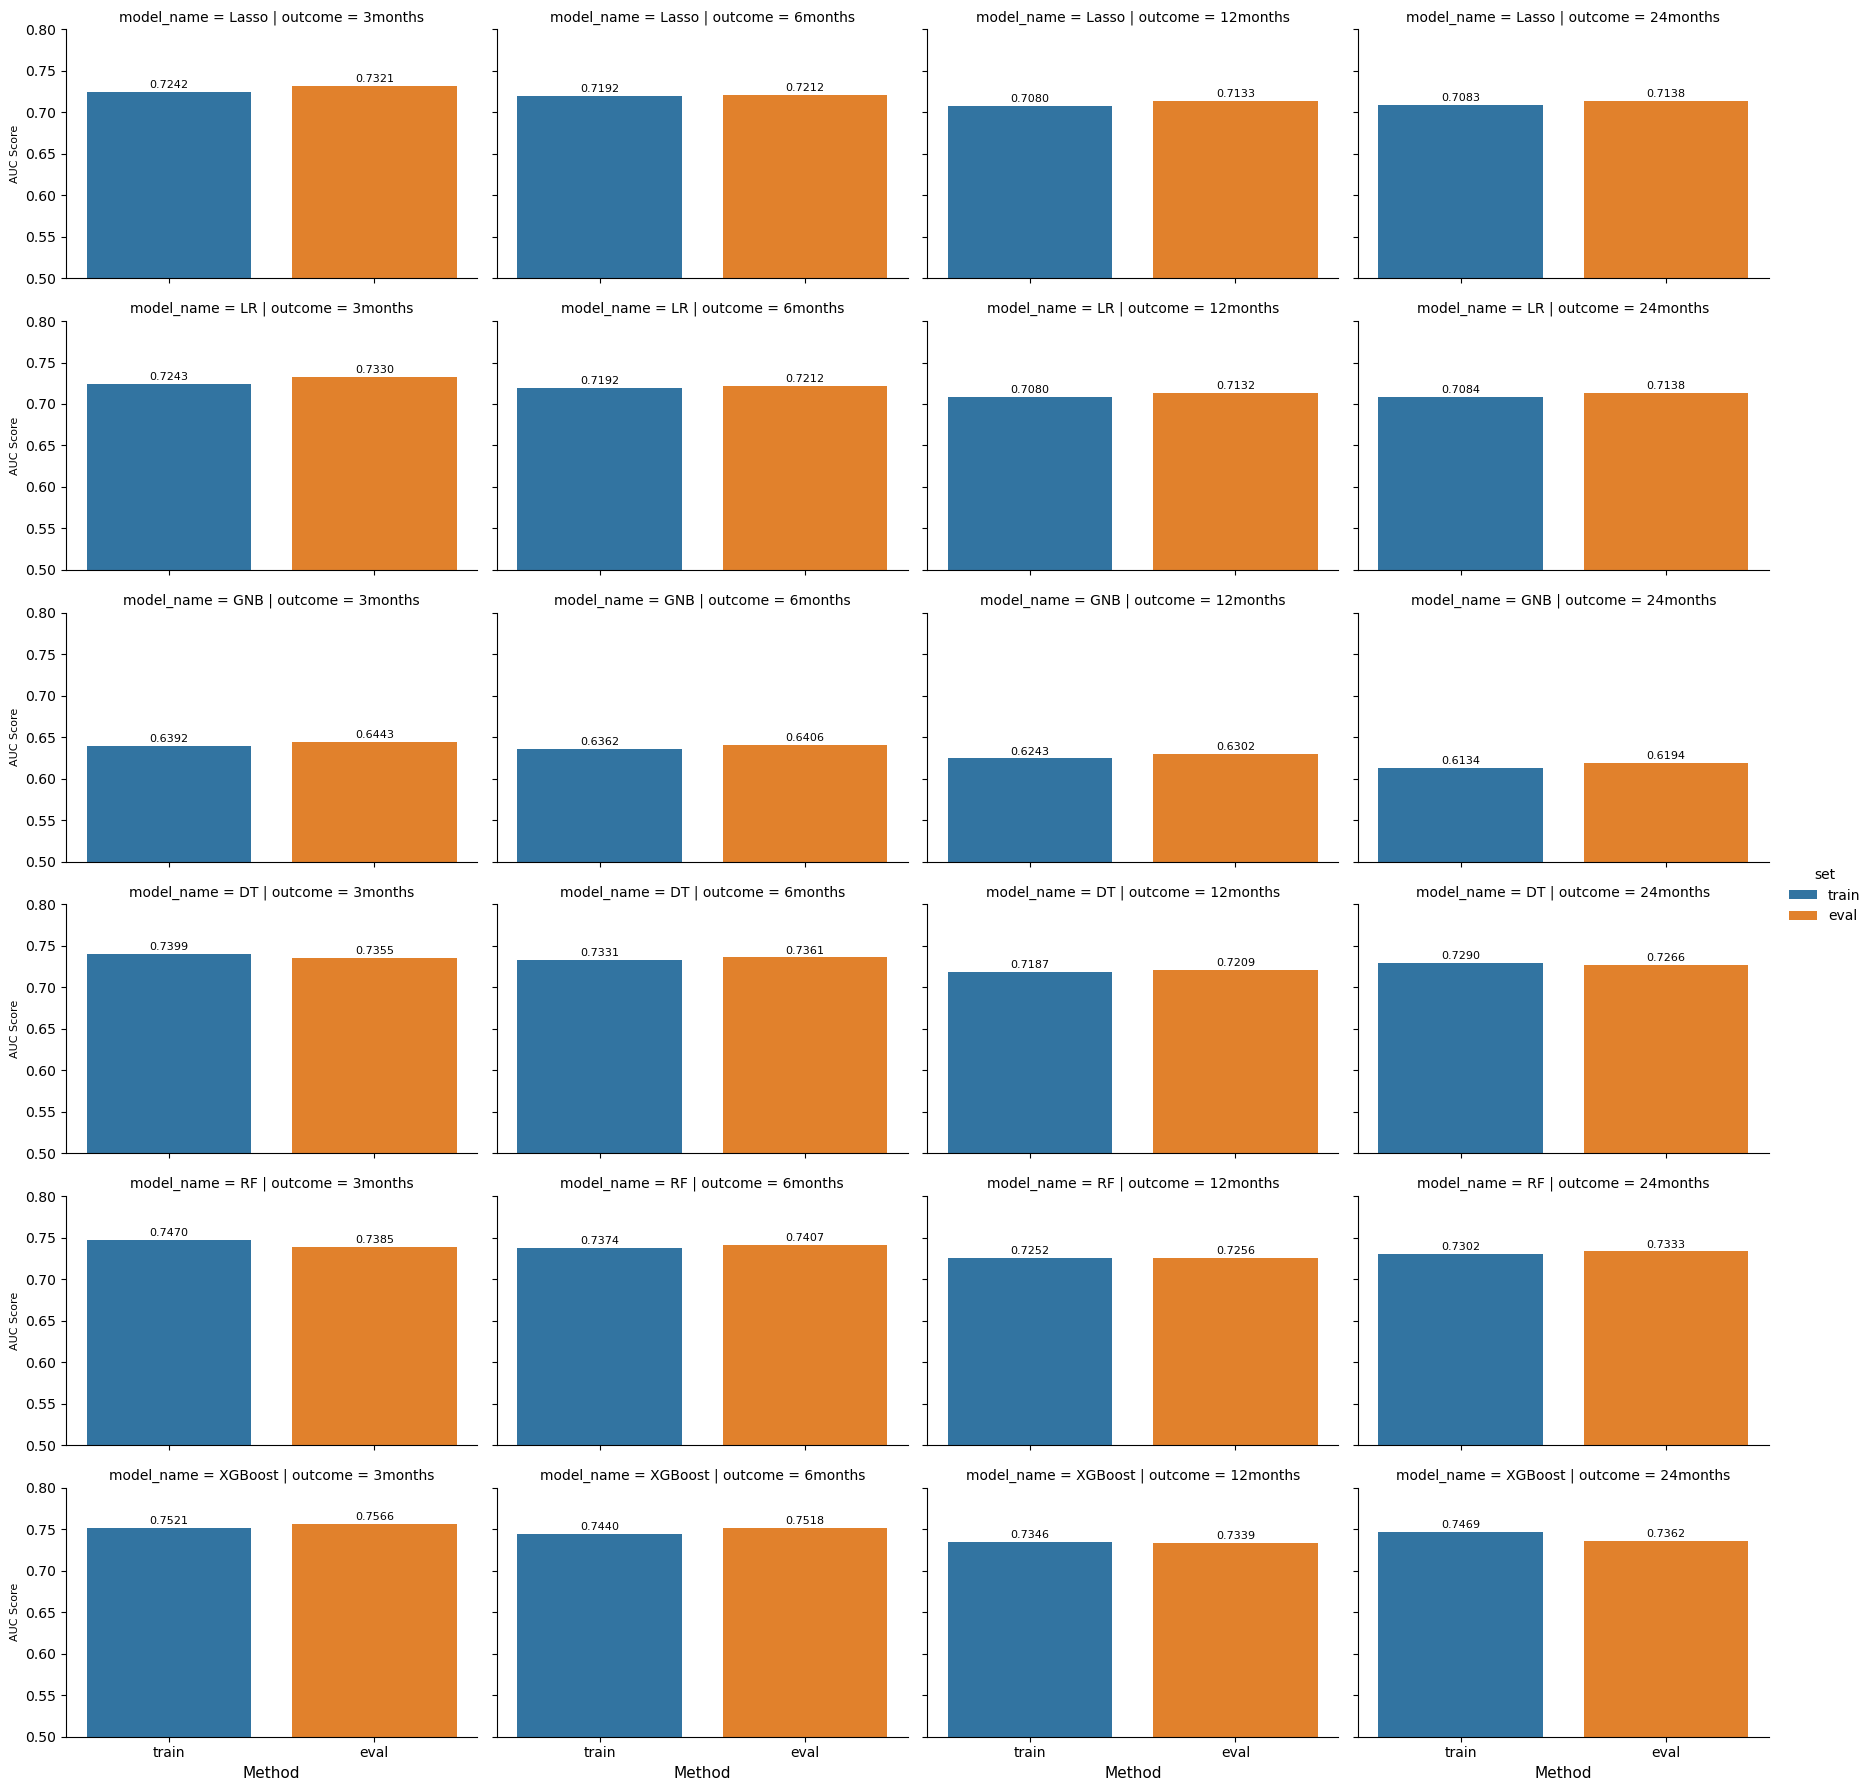

In [29]:
g = sns.FacetGrid(combine, col='outcome', row='model_name', hue = 'set', height=3, aspect=1.5, ylim=(0.5, 0.8))
g.map(sns.barplot, 'set', 'auc', order=combine.set.unique()).add_legend()

for ax in g.axes:
    for item in ax:
        for p in item.patches:
                 item.annotate("%.4f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                     textcoords='offset points')
        item.set_ylabel('AUC Score', fontsize=8)
        item.set_xlabel('Method', fontsize=11)

In [ ]:
g = sns.FacetGrid(summary_result_Wales, col='outcome', col_wrap=2, height=3, aspect=1.5, ylim=(0.5, 0.8))
g.map(sns.barplot, 'model_name', 'auc', order=summary_result_Wales.model_name.unique()).add_legend()

for ax in g.axes:
    for p in ax.patches:
             ax.annotate("%.4f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                 textcoords='offset points')
    ax.set_ylabel('AUC Score', fontsize=8)
    ax.set_xlabel('Method', fontsize=11)

In [ ]:
g = sns.FacetGrid(summary_result_Scotland, col='outcome', col_wrap=2, height=3, aspect=1.5, ylim=(0.5, 0.8))
g.map(sns.barplot, 'model_name', 'auc', order=summary_result_Scotland.model_name.unique()).add_legend()

for ax in g.axes:
    for p in ax.patches:
             ax.annotate("%.4f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                 textcoords='offset points')
    ax.set_ylabel('AUC Score', fontsize=8)
    ax.set_xlabel('Method', fontsize=11)

In [ ]:
g = sns.FacetGrid(summary_result_train, col='outcome', col_wrap=2, height=3, aspect=1.5, ylim=(0.5, 0.8))
g.map(sns.barplot, 'model_name', 'auc', order=summary_result_train.model_name.unique()).add_legend()

for ax in g.axes:
    for p in ax.patches:
             ax.annotate("%.4f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                 textcoords='offset points')
    ax.set_ylabel('AUC Score', fontsize=8)
    ax.set_xlabel('Method', fontsize=11)

In [ ]:
target_models = summary_result.model_name.unique()
model_difference = []
for outcome in target_outcomes:
    for target_model in target_models:
        train_auc = summary_result_train[(summary_result_train.outcome == outcome)&(summary_result_train.model_name == target_model)]['auc'].values[0]
        eval_auc = summary_result[(summary_result.outcome == outcome)&(summary_result.model_name == target_model)]['auc'].values[0]
        Wales_auc = summary_result_Wales[(summary_result_Wales.outcome == outcome)&(summary_result_Wales.model_name == target_model)]['auc'].values[0]
        Scotland_auc = summary_result_Scotland[(summary_result_Scotland.outcome == outcome)&(summary_result_Scotland.model_name == target_model)]['auc'].values[0]
        trainVSeval = (train_auc - eval_auc)*100
        trainVSWales = (train_auc - Wales_auc)*100
        trainVSScotland = (train_auc - Scotland_auc)*100
        model_difference.append([outcome, target_model, trainVSeval, trainVSWales, trainVSScotland])

pd.DataFrame(model_difference, columns=['outcome', 'target_model','trainVSeval', 'trainVSWales', 'trainVSScotland'])
        

In [ ]:
#Visualise
bar = sns.catplot(x = "outcome",       # x variable name
            y = "auc",       # y variable name            
            data = summary_result,     # dataframe to plot
            kind = "bar",
            hue = "model_name",
            height=5,
            aspect=6/2,
            ci = None)
ax = bar.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() + 0.01, 
            p.get_height() * 1.01, 
            '{0:.4f}'.format(p.get_height()), 
            color='black', rotation='horizontal', fontsize=7)
    
# listOf_Yticks = np.arange(0.5, 0.7, 0.05)
ax.set_ylim(0.4, 1)
ax.set_ylabel('AUC Score', fontsize=11)
ax.set_xlabel('Method', fontsize=11)

In [ ]:
best_model_dt.feature_importances_

In [ ]:
best_model_dt = pickle.load(open('../Models/12months/DT.sav', 'rb'))

# pd.DataFrame([best_model3.feature_importances_], columns=X.columns).T.sort_values(0, ascending=False)
sorted_idx = best_model_dt.feature_importances_.argsort()
plt.figure(figsize=(3,4))
plt.barh(X.columns[sorted_idx][-10:], best_model_dt.feature_importances_[sorted_idx][-10:])
plt.xlabel("Decision Tree Feature Importance")
plt.show()

In [ ]:
dttop10 = X.columns[sorted_idx][-10:]

In [ ]:
best_model_lasso = pickle.load(open('../Models/12months/Lasso.sav', 'rb'))

# pd.DataFrame([best_model3.feature_importances_], columns=X.columns).T.sort_values(0, ascending=False)
sorted_idx = best_model_lasso.coef_[0].argsort()
plt.figure(figsize=(3,4))
plt.barh(X.columns[sorted_idx][-10:], best_model_lasso.coef_[0][sorted_idx][-10:])
plt.xlabel("Lasso Feature Importance")
plt.show()

In [ ]:
lassotop10 = X.columns[sorted_idx][-10:]

In [ ]:
list(set(dttop10).intersection(set(lassotop10)))

In [ ]:
prune_duplicate_leaves(best_model_dt)
fig = plt.figure(figsize=(30,10))
_ = tree.plot_tree(best_model_dt, 
                   feature_names=X.columns,  
                   class_names=['no asthma attack','asthma attack'],
                   filled=True,)
plt.savefig('../FinalData/dt.png',format='png',bbox_inches = "tight")

## Minimum depth DT

In [ ]:
%%time
#DT with minimum max of depth

#EXECUTE model training
X = trainingData[features_columns]
X_test = evaluationData[features_columns]
target_outcome = '12months'

print(target_outcome)
y = trainingData[target_outcome]
y_test = evaluationData[target_outcome]
#Build models -> it can be commented if the models have been trained

if os.path.isfile('../Models/dt_minimum_depth.sav'):
    dt_model = pickle.load(open('../Models/dt_minimum_depth.sav', 'rb'))
else:
    dt_model = DecisionTreeClassifier(class_weight='balanced', max_depth=3, splitter='best', random_state=1234)
    dt_model.fit(X, y)
    pickle.dump(dt_model, open('../Models/dt_minimum_depth.sav', 'wb'))    
    

result = summariseResult (X_test, y_test, dt_model)
print("DT done")

In [ ]:
result

In [ ]:
prune_duplicate_leaves(dt_model)
fig = plt.figure(figsize=(15,10))
_ = tree.plot_tree(dt_model, 
                   feature_names=X.columns,  
                   class_names=['no asthma attack','asthma attack'],
                   filled=True)
plt.savefig('../FinalData/dt_minimumdepth.png',format='png',bbox_inches = "tight")

# 6months

In [ ]:
%%time

target_outcome = 'outcome_combined_6months'
y = trainingData[[target_outcome]]

#model parameters
params = {'xgb_lr': 0.6,
         'xgb_maxdepth': 7}
#EXECUTE model training

kf = StratifiedKFold(n_splits=n_splits, random_state=1234, shuffle=True)
kf.get_n_splits(X)
models2 = pd.DataFrame(columns=['modelname', 'class_ratio'])
summary_result2 = []
cols = ['model_name', 'class_ratio', 'acc','spec','sens','auc', 'auprc', 'balance_accuracy', 'f1_score', 'ppv', 'npv']
split_counter = 0

#train model
for train_index, test_index in kf.split(X, y):
    #split data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    #Build models -> it can be commented if the models have been trained
    models_temp = pd.DataFrame(build_models(X_train, y_train[target_outcome], params, split_counter), columns=['modelname', 'class_ratio'])
    models2 = pd.concat([models2,models_temp]).reset_index(drop=True)
    split_counter+=1
        
#evaluate model
for modelname, classratio in models2.values:
    # print('======================================================================')
    print(modelname)
    model = pickle.load(open('./models/'+ target_outcome + '/'+ modelname + '.sav', 'rb'))
    summary_result2.append((str(model), classratio, ) + summariseResult (X_test, y_test[target_outcome], model) )       


summary_result2 = pd.DataFrame(summary_result2, columns=cols)
summary_result2['model_num'] = summary_result2.index
# summary_result1['method_name'] = summary_result1.apply(lambda x: 'LR' if x.model_num%2 == 0 else 'XGBoost', axis=1)


In [ ]:
print(target_outcome)
summary_result2['model_name'] = summary_result2.apply(lambda x: modelNameFixer(x.model_name), axis=1)
summary_result2.groupby('model_name').mean().sort_values(['auc'], ascending=False)

In [ ]:
summary_result2.to_csv("summaryResult_outcome2.csv")
summary_result2 = pd.read_csv("summaryResult_outcome2.csv")

bar = sns.catplot(x = "model_name",       # x variable name
            y = "auc",       # y variable name            
            data = summary_result2,     # dataframe to plot
            kind = "bar",
            height=5,
            aspect=5/2.5,
            ci = None)
ax = bar.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() + 0.01, 
            p.get_height() * 1.01, 
            '{0:.4f}'.format(p.get_height()), 
            color='black', rotation='horizontal', fontsize=11)
    
# listOf_Yticks = np.arange(0.5, 0.7, 0.05)
ax.set_ylim(0.4, 1)
ax.set_ylabel('AUC Score', fontsize=11)
ax.set_xlabel('Method', fontsize=11)

In [ ]:
best_model2 = pickle.load(open('./models/outcome_combined_6months/0DTModel.sav', 'rb'))

# pd.DataFrame([best_model3.feature_importances_], columns=X.columns).T.sort_values(0, ascending=False)
sorted_idx = best_model2.feature_importances_.argsort()
plt.figure(figsize=(5,7))
plt.barh(X.columns[sorted_idx][-10:], best_model2.feature_importances_[sorted_idx][-10:])
plt.xlabel("Decision Tree Feature Importance")
plt.show()

In [ ]:
best_model2 = pickle.load(open('./models/outcome_combined_6months/0RFModel.sav', 'rb'))

# pd.DataFrame([best_model3.feature_importances_], columns=X.columns).T.sort_values(0, ascending=False)
sorted_idx = best_model2.feature_importances_.argsort()
plt.figure(figsize=(5,7))
plt.barh(X.columns[sorted_idx][-10:], best_model2.feature_importances_[sorted_idx][-10:])
plt.xlabel("Random Forest Feature Importance")
plt.show()

In [ ]:
best_model2 = pickle.load(open('./models/outcome_combined_6months/0XGBoostModel.sav', 'rb'))

# pd.DataFrame([best_model3.feature_importances_], columns=X.columns).T.sort_values(0, ascending=False)
sorted_idx = best_model2.feature_importances_.argsort()
plt.figure(figsize=(5,7))
plt.barh(X.columns[sorted_idx][-10:], best_model2.feature_importances_[sorted_idx][-10:])
plt.xlabel("XGBoost Feature Importance")
plt.show()

# 12 months

In [ ]:
target_outcome = 'outcome_combined_12months'
y = trainingData[[target_outcome]]

#model parameters
params = {'xgb_lr': 0.6,
         'xgb_maxdepth': 10}

In [ ]:
%%time

#EXECUTE model training

kf = StratifiedKFold(n_splits=n_splits, random_state=1234, shuffle=True)
kf.get_n_splits(X)
models3 = pd.DataFrame(columns=['modelname', 'class_ratio'])
summary_result3 = []
cols = ['model_name', 'class_ratio', 'acc','spec','sens','auc', 'auprc', 'balance_accuracy', 'f1_score', 'ppv', 'npv']
split_counter = 0

#train model
for train_index, test_index in kf.split(X, y):
    #split data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    #Build models -> it can be commented if the models have been trained
    models_temp = pd.DataFrame(build_models(X_train, y_train[target_outcome], params, split_counter), columns=['modelname', 'class_ratio'])
    models3 = pd.concat([models3,models_temp]).reset_index(drop=True)
    split_counter+=1
        
#evaluate model
for modelname, classratio in models3.values:
    # print('======================================================================')
    print(modelname)
    model = pickle.load(open('./models/'+ target_outcome + '/'+ modelname + '.sav', 'rb'))
    summary_result3.append((str(model), classratio, ) + summariseResult (X_test, y_test[target_outcome], model) )       


summary_result3 = pd.DataFrame(summary_result3, columns=cols)
summary_result3['model_num'] = summary_result3.index
# summary_result1['method_name'] = summary_result1.apply(lambda x: 'LR' if x.model_num%2 == 0 else 'XGBoost', axis=1)


In [ ]:
print(target_outcome)
summary_result3['model_name'] = summary_result3.apply(lambda x: modelNameFixer(x.model_name), axis=1)
summary_result3.groupby('model_name').mean().sort_values(['auc'], ascending=False)

In [ ]:
summary_result3.to_csv("summaryResult_outcome3.csv")
summary_result3 = pd.read_csv("summaryResult_outcome3.csv")

bar = sns.catplot(x = "model_name",       # x variable name
            y = "auc",       # y variable name            
            data = summary_result3,     # dataframe to plot
            kind = "bar",
            height=5,
            aspect=5/2.5,
            ci = None)
ax = bar.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() + 0.01, 
            p.get_height() * 1.01, 
            '{0:.4f}'.format(p.get_height()), 
            color='black', rotation='horizontal', fontsize=11)
    
# listOf_Yticks = np.arange(0.5, 0.7, 0.05)
ax.set_ylim(0.4, 1)
ax.set_ylabel('AUC Score', fontsize=11)
ax.set_xlabel('Method', fontsize=11)

In [ ]:
best_model3 = pickle.load(open('./models/outcome_combined_12months/0DTModel.sav', 'rb'))

# pd.DataFrame([best_model3.feature_importances_], columns=X.columns).T.sort_values(0, ascending=False)
sorted_idx = best_model3.feature_importances_.argsort()
plt.figure(figsize=(5,7))
plt.barh(X.columns[sorted_idx][-10:], best_model3.feature_importances_[sorted_idx][-10:])
plt.xlabel("Decision Tree Feature Importance")
plt.show()

In [ ]:
best_model3 = pickle.load(open('./models/outcome_combined_12months/0RFModel.sav', 'rb'))

# pd.DataFrame([best_model3.feature_importances_], columns=X.columns).T.sort_values(0, ascending=False)
sorted_idx = best_model3.feature_importances_.argsort()
plt.figure(figsize=(5,7))
plt.barh(X.columns[sorted_idx][-10:], best_model3.feature_importances_[sorted_idx][-10:])
plt.xlabel("Random Forest Feature Importance")
plt.show()

In [ ]:
best_model3 = pickle.load(open('./models/outcome_combined_12months/0XGBoostModel.sav', 'rb'))

# pd.DataFrame([best_model3.feature_importances_], columns=X.columns).T.sort_values(0, ascending=False)
sorted_idx = best_model3.feature_importances_.argsort()
plt.figure(figsize=(5,7))
plt.barh(X.columns[sorted_idx][-10:], best_model3.feature_importances_[sorted_idx][-10:])
plt.xlabel("XGBoost Feature Importance")
plt.show()